In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.plotting import plot_lifetimes
from sklearn.metrics import roc_auc_score
import sys
sys.path.append('Scripts')

# Scripts
from Scripts.load_data import load_DLF
from Scripts import km
from Scripts import DLFwrapper

<br>
<p style="font-size:30px;">Deep Landscape Forecasting for Real-time Bidding Advertising</p>
<p style="font-size:30px;">(Winter 2020/21)</p>
<br>

# Introduction

In their Paper, Ren et al. (2018) address the problem of bid landscape forecasting in real-time online advertisement auctions. They employ and compare different survival analysis methods and propose a novel way of predicting the price distributions, improving on past research in multiple ways.

In the following, we give a brief introduction into how real-time bidding works, what survival analysis is, and how the two can be brought together in an insightful way. Afterwards, we discuss the key points of the proposed new method and how it improves upon previous work.

# Real-Time Bidding (RTB)

Real-time bidding describes the mechanism of advertisers bidding on ad slots in real time while a page is loading for the accessing user.
The bids are normally submitted automatically by the advertisers and based on features like region, time, ad dimensions, domain, etc.

The bids are collected by the publisher, and the ad of the highest bidding advertiser is displayed.
Often, it is a **second-price** format, meaning that the auction winner only pays the second highest bid, which is then defined as market price.
This format ensures that the participants' bids match their true reservation values (Yuan et al., 2014).

Predicting this market price is a crucial but challenging problem, since the market price is highly dynamic across different auctions and it is infeasible to model all advertisers' bidding strategies individually (Ren et al., 2018).\
Furthermore, only the winner of an auction knows its true market price. Everyone else just knows that the market price must be higher than (or equal to) their own bid. 
In survival analysis, this property is called "right-censored". Section 3 explains this in more detail.

The following graphic illustrates the RTB mechanism in 12 steps:

<img src="Image/RTB.jpeg" width="600">
<center>Source: iPinYou Global RTB Bidding Algorithm Competition Dataset, Liao et al. (2020)</center>

# Survival Analysis


Also called "Time to Event"-Analysis, Survival Analysis estimates the time until the occurrence of an event for different individuals of a population.\
It was originally developed by medical researchers and data analysts to model the lifespan of subjects in medical studies, prominent examples being survival times in an ICU or leukemia progression.\
In these cases, the event of interest would be "death", as the name suggests. However, over time, the methods have started to see usage in many other applications too, such as credit default risk, or - like in our case - auctions.

There are two main functions in survival analysis trying to be estimated. We handle $T$ as a continuous random variable.
1) **Survival Function**
$$S(t)   = Pr(T>t)$$


<center>"Probability of surviving beyond time t"<center>                                  

2) **Hazard Function**
$$h(t)   = \lim \limits_{h \to 0} \frac{Pr(T < t + h | T > t)}{h}$$
 
<center>"Probability of dying at the next time step, given that the subject is alive now"<center>                         

\
Conceptually, the hazard function represents the rate of decrease of the (true) survival function at every time step.

## Right-Censored Data
We speak of right-censored data when we do not know if the event in question occurred, e.g. because a subject left the study, or the study ended.

The following figure shows the lifetimes (in years) for each subject of a population. The blue lines represent the right-censored data while the red lines represent the event occurring at some point during the study.

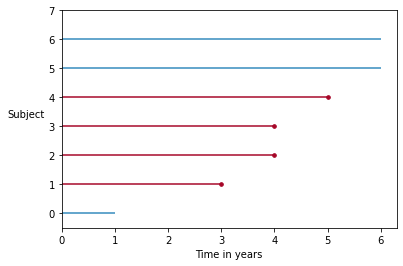

In [16]:
events = pd.DataFrame({"Time" : [5, 6, 6, 3, 4, 4, 1], "Event": [1, 0, 0, 1, 1, 1, 0] })
ax = plot_lifetimes(events['Time'], events['Event']);
ax.set_xlabel("Time in years")
ax.set_ylabel("Subject", ha="right", rotation=0);

Survival analysis assumes that the censoring is not related to the probability of the event occurring.\
For example, if we analyze the progression of an illness and a patient stops showing up to the study because he feels much better, it would violate this assumption and the data point should be excluded.

**Note**: There also exists left-censored data, but it is irrelevant to our use case and therefore not covered in this tutorial.

## Kaplan-Meier Analysis

The simple go-to approach for modeling a survival function is the non-parametric Kaplan-Meier Estimator.\
KM computes probabilities of event occurrences at a certain time and multiplies them by any earlier probabilities to get a final estimate. Therefore, it counts how many people died/survived at each data point in time.

For every time step $t_i \leq t$, we divide the number of occurring events $d_i$ by the number of remaining non-censored subjects $n_i$ ("subjects at risk"), obtaining the probability of dying at that time step. Consequently, by subtracting this value from 1, we obtain the probability of not dying. The product of all these probabilities yields the survival function at time $t$.

$$S(t) = Pr(T > t) = \prod_{t_i \leq t}(1 - Pr(t_i \leq t)) = \prod_{t_i \leq t} \left(1 - \frac{d_i}{n_i}\right)$$

---

To illustrate briefly how KM works, we calculate the survival function by hand on our 7 row dataset from before.

In [17]:
events.sort_values("Time")

,Time,Event
6,1,0
3,3,1
4,4,1
5,4,1
0,5,1
1,6,0
2,6,0


The calculation is executed as follows:
$$S(0) = 1$$
$$S(1) = 1 \cdot \left(1 - \frac{0}{7}\right) = 1$$
$$\text{S(2) is omitted because no event or censorship happened at this time step.}$$
$$S(3) = 1 \cdot \left(1 - \frac{1}{6}\right) = \frac{5}{6}$$
$$S(4) = \frac{5}{6} \cdot \left(1 - \frac{2}{5}\right) = \frac{1}{2}$$
$$S(5) = \frac{1}{2} \cdot \left(1 - \frac{1}{3}\right) = \frac{1}{3}$$
$$S(6) = \frac{1}{3} \cdot \left(1 - \frac{0}{2}\right) = \frac{1}{3}$$

The computation produces in the following plot. It shows a median survival time of 5 years.\
Censorship is indicated by a vertical line.

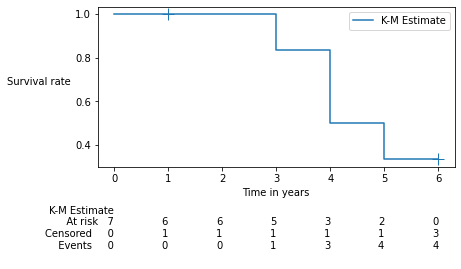

In [18]:
kme = KaplanMeierFitter()
kme.fit(events['Time'], events['Event'], label = 'K-M Estimate')
ax = kme.plot(ci_show=False, at_risk_counts=True, show_censors=True)
ax.set_ylabel("Survival rate", ha="right", rotation=0)
ax.set_xlabel("Time in years");

In [20]:
print(f"50% of subjects survive the first {kme.median_survival_time_:.0f} years.")

50% of subjects survive the first 5 years.


## Transitioning to RTB

For our actual use case, we change the premise and context of traditional survival analysis.

The "time" variable is replaced by **market price**. \
The event in question is **winning the auction**. \
Losing the auction is considered **right-censorship**, because the market price is unknown.

The new survival function $S(b)$, where $b$ is some bid, indicates the **losing probability** at this bid size.

# RTB Data

For our work, we are using real RTB data from iPinYou.com, published in 2013. It contains 64.7 million bidding records across 9 different campaigns, collected over 10 days.\
Each row contains a true market price $z$, a bid price $b$ (both in Chinese Yuan per CPM), and 16 categorical attributes $x$, like user and ad slot data.

In the following, we will be exploring data from one single campaign, apply the KM estimator again, and finally show the approach developed by Ren et al.

## EDA
The campaign we use is number 2261, which contains 1.031.479 rows in total. The first 7 days of data are used as train set, while the last 3 days are used as test set.
Feature Engineering is not covered, as it is irrelevant to the tutorial, but it leads to all values across all $x$ features being mapped to unique integer numbers for convenience in model training. The file `featindex.txt` contains this mapping, and we use it to translate the features back into readable format.

Firstly, we will load the data and check its shape.

In [21]:
train, test = load_DLF("data\\2261", remap_colnames=True)
combined = train.append(test, ignore_index=True)
print(f"Data shape: {combined.shape}")

D:\Dokumente\Winfo\WiSe2021\Seminar Information Systems\Final Paper\Tutorial
Loading: data\2261\featindex.txt
Loading: data\2261\test.yzbx.txt
Loading: data\2261\train.yzbx.txt


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Remapping x values from feature index.


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.17s/it]


Data shape: (1031479, 19)


In [22]:
combined.head()

,Click,Market_Price,Bid,weekday,hour,IP,region,city,adexchange,domain,slotid,slotwidth,slotheight,slotvisibility,slotformat,creative,advertiser,useragent,slotprice
0,0,289,67,4,17,27.24.140.*,183,194,3,a05e2e05e42bd2dd5d5c0e182f9dab4e,Astro_F_bottom_Width,1000,90,Na,Na,12633,2261,windows_chrome,11-50
1,0,181,45,4,17,27.24.140.*,183,194,3,a05e2e05e42bd2dd5d5c0e182f9dab4e,Astro_F_Rectangle,300,250,Na,Na,12622,2261,windows_chrome,1-10
2,0,87,37,4,15,61.238.156.*,394,394,3,120b1f55d5a56547dad95f33d568fdee,Finance_GGCX_F_GGMG_ZQ1,180,600,Na,Na,12615,2261,windows_chrome,11-50
3,0,20,38,4,14,123.166.5.*,65,66,3,79a8816bf916f6e761143c4f8a826fd,Finance_GGCX_F_GPJJ_ZQ1,180,600,Na,Na,12615,2261,windows_ie,11-50
4,0,147,12,4,18,10.246.112.*,0,0,1,f7b4f217ffc9ee3bd9a3493b0d70355e,mm_14149469_2225536_13238633,160,600,Na,Na,12613,2261,windows_ie,0


The feature `Click` is not relevant to us and can be ignored.

As mentioned in section 2, bidders who lose the auction do not know the true market price. We therefore add a column `Censored` to reflect this:

In [23]:
combined["Censored"] = (combined.Bid <= combined.Market_Price).astype("int")

We examine some descriptive statistics:

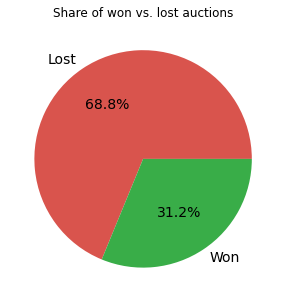

In [24]:
plt.figure(figsize=(5,5))
combined["Censored"].value_counts().plot.pie(labels=["Lost", "Won"], autopct="%1.1f%%", textprops={'fontsize': 14}, colors=["#d9544d", "#39ad48"])
plt.title("Share of won vs. lost auctions")
plt.ylabel("");

We see a winrate of 31.2%

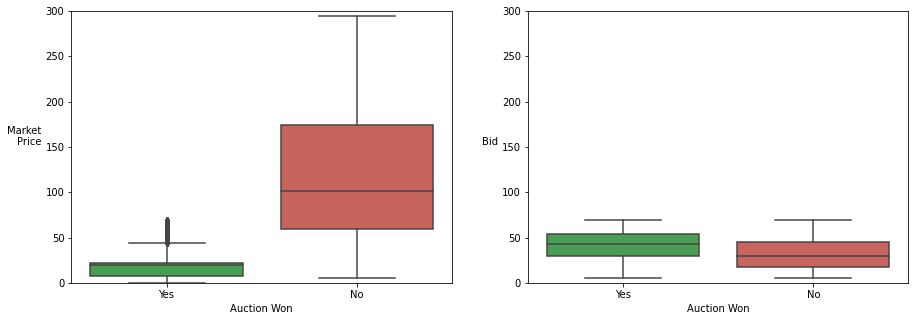

In [25]:
_, chart = plt.subplots(1, 2, figsize=(15, 5))
chart = chart.ravel()
plt.sca(chart[0])
sns.boxplot(x="Censored", y="Market_Price", data=combined, order=[0, 1], palette=[sns.xkcd_rgb["medium green"], sns.xkcd_rgb["pale red"]])
plt.ylabel("Market\nPrice", ha="right", rotation=0)
plt.xlabel("Auction Won")
plt.xticks(ticks=[1, 0], labels=["No", "Yes"])
plt.ylim(0, 300);

plt.sca(chart[1])
sns.boxplot(x="Censored", y="Bid", data=combined, order=[0, 1], palette=[sns.xkcd_rgb["medium green"], sns.xkcd_rgb["pale red"]])
plt.ylabel("Bid", ha="right", rotation=0)
plt.xlabel("Auction Won")
plt.xticks(ticks=[0, 1], labels=["Yes", "No"])
plt.ylim(0, 300);

Notable is the difference in average market price between winning and losing logs.
This reflects the second-price auction mechanism and highlights the importance of including losing data in training to overcome this bias (more on this in section 5).

Furthermore, the maximum bid of 69 against the maximum market price of 294 indicates that the data set does not contain all submitted bids, which is important to keep in mind.

Finally, we plot the distribution of market prices in the dataset and the corresponding cumulative proportion.
Most interesting is the spike at 20.

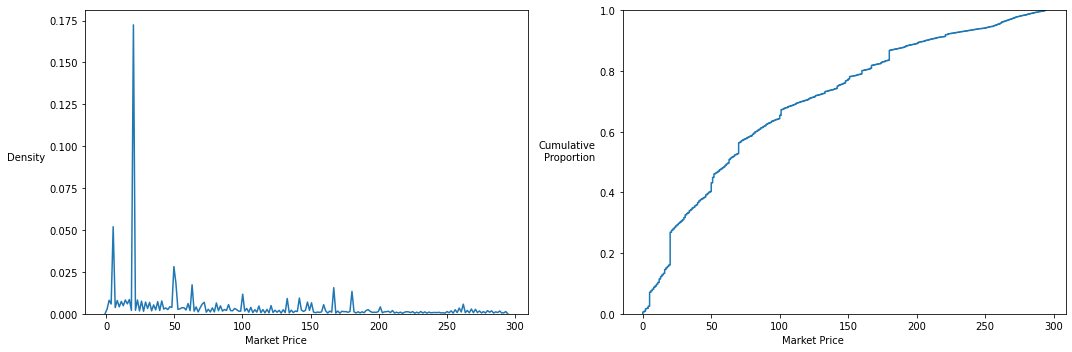

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

price = combined["Market_Price"]
sns.kdeplot(price, bw_adjust=0.05, ax=axes[0])
axes[0].set_ylabel("Density", ha="right", rotation=0)
axes[0].set_xlabel("Market Price", ha="right", rotation=0)
sns.ecdfplot(price, ax=axes[1])
axes[1].set_ylabel("Cumulative\nProportion", ha="right", rotation=0)
axes[1].set_xlabel("Market Price", ha="right", rotation=0)
plt.tight_layout();

These plots show a sophisticated market price distribution.\
For now we should take away from this that the market price does not closely follow some predefined distribution like log-normal or Gaussian, which are often assumed in this context. Doing so loses information.

## Applying the Kaplan-Meier Estimator

Before transitioning to the final model, we apply our already established model to the use case.

In [18]:
bid = combined.Bid
win = 1 - combined.Censored
kme = KaplanMeierFitter()
kme.fit(bid, event_observed=win, timeline=list(range(301)));

As already mentioned, the y-axis represents the **share of auctions not won** at any given bid price.

Since we are only given bids up to 69, there is no way to model bids that led to the high observed market prices.

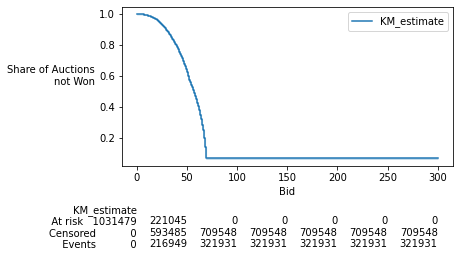

In [19]:
ax = kme.plot(at_risk_counts=True)
ax.set_ylabel("Share of Auctions\nnot Won", ha="right", rotation=0)
ax.set_xlabel("Bid");

Especially interesting in this context is the cumulative density function, which serves as the **average win rate** of a bid.

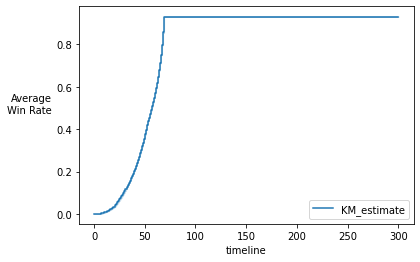

In [20]:
kme.plot_cumulative_density()
plt.ylabel("Average\nWin Rate", ha="right", rotation=0);

# Deep Landscape Forecasting


## The Bridge To Deep Learning
How to move from a simple descriptive survival model such as Kaplan-Meier to Deep Learning might not seem intuitive at first.

Most deep survival models essentially predict the Hazard function and construct the survival function from its cumulative product, much like in Kaplan-Meier. Others assume a distribution and just fit its parameters to the data.

Ren et al. pursue the former of the two, in fact with a very organic approach based on probability theory, with which they are even able to construct individual price distributions for single auctions. More details are provided in section 5.4.

## The Problem

As already mentioned in section 2, the problem in an RTB scenario is to forecast the market price, especially for the losing advertisers since they have no idea of the historical price distribution of a given ad.\
Since traditional prediction models have no way of properly dealing with these **censored** observations, this is the reason for using survival analysis in the first place.

How can we now come up with a cost-effective bidding strategy if it is infeasible to model each advertiser's bidding strategy?

In their paper, Ren et al. bring up several more survival analysis models (partly deep learning) that have been proposed in past literature, but each of them suffers from at least one major drawback.

    1. They cannot do fine-grained prediction, but have to predict over segments and take averages
    2. They assume some kind of predefined distribution form, for example log-normal or Gaussian
    3. They either only consider winning or losing logs for training, but never both

Kaplan-Meier, for instance, suffers from number 1.

Throughout this notebook, we have learned how and why all three of these things should be avoided. Ren et al. propose a new model that is the first one to do so.

## The Novelties
* **Fine-grained prediction**: Distributions are predicted for each auction instead for a sample segment. Thus, predictions are individualized.


* **No assumption of distribution forms**: Forecasts without prior assumptions about the market price distribution.


* **Novel Censorship loss function**: A comprehensive loss function, that handles censorship and can use winning as well as losing data for learning.

## The Approach


### Definitions

We are dealing with a set of $L$ integer bid prices $0<b_1<b_2<...<b_L$. 

In our case, $L = 300$ (over the full data set). Therefore, we can separate the continuous space into discrete bins without losing information:

$$V_l = (b_l, b_{l+1}] \hspace{1cm}\text{ with } \hspace{1cm}l \in \{1, 2, ..., L\}$$ 

We define $b_0=0$.

Since the bids are always an integer and we use every possible bid, it must hold that: $b_{l+1}-b_l=1$.

With this, we can define the winning and losing functions over discrete space:

$$W(b_l) = Pr(z<b_l) = \sum_{j<l} Pr(z\in V_j)$$
$$S(b_l) = Pr(z\geq b_l) = \sum_{j\geq l} Pr(z\in V_j) = 1 - W(b_l)$$

The "losing" function is the **survival function** in this application.

<br>

The discrete market price probability function (P.D.F.) at the $l$-th price interval is described as:

$$p_l = Pr(z\in V_l) = W(b_{l+1}) - W(b_l) = S(b_l) - S(b_{l+1})$$ 
<center> "What is the probability that the true market price $z$ lies within $V_l$?" </center>
<br>

The conditional winning probability, also known as **Hazard**, gives us the probability of just narrowly winning the auction by proposing a bid at the $l$-th price interval:

$$h_l = Pr(z\in V_l | z \geq b_{l-1}) = \frac{Pr(z\in V_l)}{Pr(z\geq b_{l-1})} = \frac{p_l}{S(b_{l-1})} = \frac{S(b_l) - S(b_{l+1})}{S(b_{l-1})}$$
<center> "The probability that the true market price $z$ lies within $V_l$ given that $z$ is larger than all bid prices below $b_l$" </center>
<br>


### RNN Architecture

The paper separates the training data into winning and losing logs and trains a deep RNN to predict the conditional winning probabilities $h_l$. As input it uses feature vectors $x$ and bids $b$. \
Since $x$ consists of 16 categorical features, we want to avoid one-hot encoding them. Thus, $x$ is fed through an embedding matrix $e$, and $e(x)$ is passed to the model instead. For convenience, we will still write $x$ in the following notation.

For every case $i$, each cell predicts the conditional winning probability $h_l^i$ of the bid, starting with 1 and increasing by 1 until their actual bid $b_l$ is reached.

$$h_l^i = Pr(z \in V_l | z \geq b_{l-1}, x^i; \theta) = f_\theta(x^i, b_l | r_{l-1})$$
<br>

The process is best described by the following figure.

<img src="Image/rnn_figure.png" >
<center>
    Source: Ren et al. (2019)
</center>

Note that only winning logs know the true market price and can calculate $p_z$ for the Loss $L_1$, which is thematized in the next section.

<br>

**Note:** The authors apparently made a mistake in their implementation. Their model actually predicts $(1-h_l^i)$. This is without consequence for the correctness of their model but should be kept in mind when trying to understand the code in this notebook.

### Loss Functions
The DLF model uses a comprehensive loss function based on two losses.

The first loss $L_1$ is called ANLP loss and is based on the probability distribution function (P.D.F.). It minimizes the negative log-likelihood of the market price prediction over winning logs only. Since we also use it for evaluation, a more detailed description with code is provided in section 6.1.1.\
However, keep in mind that the **evaluation** function can be applied over both winning and losing logs after making predictions with **any model**, while the **loss** function is used on winning logs during training **DLF only**.

<br>

The second loss $L_2$ is based on the winning probability distribution (C.D.F.) and includes winning as well as losing data. Therefore $L_2$ consists of two losses $L_{win}$ and $L_{lose}$ and is the cross entropy loss for predicting the winning probability of bidding $b^i$, given $x^i$.

$$L_2 = L_{win} + L_{lose}$$

The left subfigure shows a winning case and helps to understand the motivation of $L_{win}$. Because we are looking for a price that is just higher than the true market price $z$, the loss is designed to "push down" the winning probability in $[0,z]$ and "pull up" the probability in $(z, \infty)$, especially in $[z,b]$.
Since the true market price $z$ is not known for the losing logs (right subfigure), $L_{lose}$ instead only "pushes down" the winning probability.

<img src="Image/image-2.png" width="700">
<center>
    Source: Ren et al. (2019)
</center>

<br>

Now it is possible to minimize the negative log-likelihood over all winning and losing logs as described below, with $\alpha$ being a hyperparemeter to control the ratio of the two losses.

$$ \underset{\theta}{\operatorname{argmin}} {\alpha L_1 + (1-\alpha)L_2}$$



# Implementation

With the gathered knowledge, we can now finally apply the model!

The following hyperparameters are only a subset of the available ones, but should be sufficient to configure the model as desired.

In [2]:
params = {
          "input_file": "2261", # Input campaign number, don't change this
          "BATCH_SIZE": 128,    # Batch size
          "TRAIN_STEPS": 100,   # Number of batches to train on
          "STATE_SIZE": 128,    # Number of LSTM cells
          "LR": 0.0001,         # Learning rate
          "ALPHA": 0.25,        # Coefficient for cross entropy loss, ANLP loss is 1 - ALPHA
          "L2_NORM": 0.001,     # L2 Regularization
          "EMB_DIM": 32,        # Embedding size
         }

**Note on training steps**

One step = `BATCH_SIZE` examples, so one epoch is `len(train) / BATCH_SIZE` steps.

The train dataset we use has 687617 rows, so at  `BATCH_SIZE` of 128, we need roughly 5372 training steps for one epoch.

In [3]:
dlf = DLFwrapper.DLFModel(**params)

Placeholder Logfile created:

	DLF_2261_32_128_128_0.0001_0.001_0.25_0.75.txt

Session opened.


In [23]:
dlf.train()

TRAIN DATA winning logs size:  221454 

FULL DATA logs size:  687617 

TEST DATA winning logs size:  100477 

TEST DATA losing logs size:  243385 

TRAINING LOG:

2261	TRAIN		100	2.5544	0.5450		6.3423		5.3953		32		128		128		0.0001	0.0001		0.0010	0.25	0.75

Model saved under ./saved_model/DLF_2261_32_128_128_0.0001_0.001_0.25_0.75-100



## Load Existing Model
We have pretrained a model on 5000 batches which is loaded in the following:

In [4]:
checkpoint = f".\\saved_model\\DLF_2261_32_128_128_0.0001_0.001_0.25_0.75-5000"  # Insert saved model path here
meta = checkpoint + ".meta"

In [5]:
dlf.model.sess = dlf.model.load(meta, checkpoint, step=5000)

Get survival data to construct probability distribution (can take 20-30 minutes):

In [ ]:
hazards, bid, market_prices, prob = dlf.get_survival_data()

## Obtaining Winning Function and Market Price P.D.F.

Formally, the DLF survival function can be determined from the model output as follows:

$$S(b | x^i; \theta) = Pr(b \leq z | x^i; \theta) $$

$$= Pr(z \notin V_1, z\notin V_2, ..., z\notin V_l | x^i; \theta)$$

$$= Pr(z\notin V_1 | x^i; \theta) \cdot Pr(z\notin V_2 | z\notin V_1, x^i; \theta) \cdot ... \cdot Pr(z\notin V_{l_b} | z\notin V_1, ..., z\notin V_{l_b-1}, x^i; \theta)$$

$$= \prod_{l:l\leq l_b} \left[ 1 - Pr(z\in V_l | z \geq b_l, x^i; \theta)\right]$$

$$= \prod_{l:l\leq l_b} (1 - h_l^i)$$

In [27]:
def get_survfunc(hazarddata, **kwargs):
    # This is where the authors made a mistake.
    # The following code gives correct results, but according to their theory, it should be np.cumprod(1-hazard)
    return np.cumprod(hazarddata, **kwargs)

In section 5.4.1, we defined: $p_l = S(b_l) - S(b_{l+1})$

This means that we just need the survival function to be able to calculate the market price distribution:

In [28]:
def get_pdf(survfunc):
    return survfunc[:-1] - survfunc[1:]

Let's look at a single example:

In [31]:
def dlf_plots(example):
    print(f"Example {example}\nBid: {bid[example]}\nMarket Price: {market_prices[example]}"\
      f"\nWin Confidence: {prob[example][1]:.2}")
    
    _, chart = plt.subplots(1, 2, figsize=(16.5, 5))
    chart = chart.ravel()
    
    # Win Probability:
    survfunc = get_survfunc(hazards[example])
    win = 1 - survfunc # Get the winning function (which is just 1 - survival function)
    plt.sca(chart[0])
    plt.plot(win)
    plt.title("DLF Win Probability")
    plt.vlines(bid[example], 0, 1, color="red", linestyles="dashed", linewidth=1.5)
    plt.vlines(market_prices[example], 0, 1, color="black", linestyles="dashed", linewidth=1.5)
    plt.legend(["Winning Function", "Bid", "True Market Price"], loc="lower right")
    plt.xlabel("Price")
    
    # Discrete P.D.F:
    # The following code also gives the same result:
    # pdf = (1-hazards[example][1:]) * np.cumprod(hazards[example][:-1])  
    # It is the formal derivation from the paper (Equation 9)
    
    pdf = get_pdf(survfunc)  # Use survival function from above
    
    plt.sca(chart[1])
    plt.plot(pdf)
    plt.title("DLF Market PDF")
    plt.vlines(bid[example], 0, pdf.max(), color="red", linestyles="dashed", linewidth=1.5)
    plt.vlines(market_prices[example], 0, pdf.max(), color="black", linestyles="dashed", linewidth=1.5)
    plt.legend(["Market Price PDF Estimation", "Bid", "True Market Price"], loc="upper right")
    plt.xlabel("Price")
    

Example 124
Bid: 11
Market Price: 20
Win Confidence: 0.0049


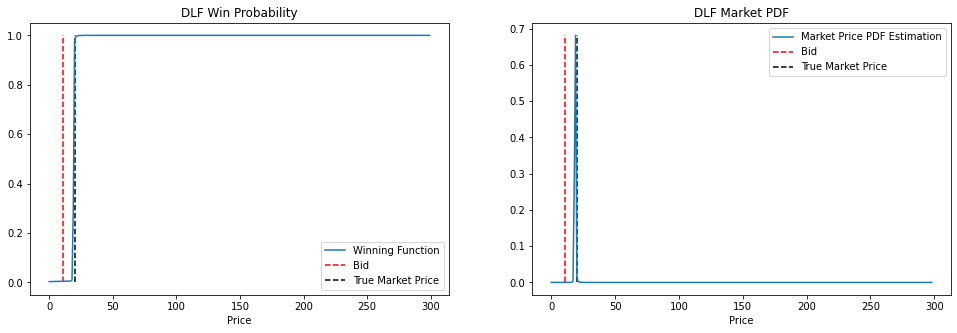

In [32]:
# Feel free to change the example
example = 124
dlf_plots(example)

As we can see, the model often predicts the market price really well, even for censored logs that never learned the market price during training!

Compare this to KM again. Note that the KM statistics are always the same over the entire data set since KM does not allow for fine-grained predictions.

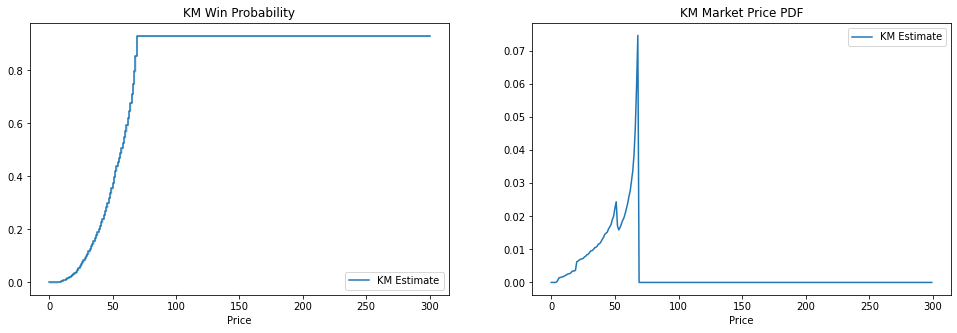

In [33]:
_, chart = plt.subplots(1,2,figsize=(16.5, 5))
chart = chart.ravel()

plt.sca(chart[0])
kme.plot_cumulative_density()
plt.title("KM Win Probability")
plt.xlabel("Price")
plt.legend(["KM Estimate"], loc="lower right")

plt.sca(chart[1])
pdf = get_pdf(kme.survival_function_.values)
plt.plot(pdf)
plt.title("KM Market Price PDF")
plt.legend(["KM Estimate"], loc="upper right")
plt.xlabel("Price");

## Evaluation Metrics

### ANLP

ANLP is the Average Negative Log Probability, or **Information Entropy**. The higher the value, the more "surprise" or uncertainty our model involves. We use it to evaluate the quality of the predicted probability distribution.

Define the learned forecasting function of a model as $p_z(z^i|x^i)$.

This describes the model's confidence of the true market price being the market price. The higher this confidence, the better it models the market.

ANLP is then defined as:
$$\bar{P} = -\frac{1}{|D_{test}|} \sum_{(x^i, z^i)\in D_{test}} \log p_z(z^i|x^i)$$

Remember that for our case: $p_l = S(b_l) - S(b_{l+1})$

Translated to the formula's format: $p_z = S(z^i|x^i) - S(z^i+1|x^i)$

This means we just need the predicted survival function at market price and the price after that (same as in 6.2). Then we logarithmize the difference, negate it, and calculate the average.

In [34]:
def anlp_loss(surv_data, prices):
    # Calculate the row-wise survival functions (one for each auction)
    # At each individual price level, this yields the predicted probability to lose the auction if we would bid 
    # exactly that much
    cumprods = get_survfunc(surv_data, axis=1)
    
    # In every row, select the survival probability at exactly market price:
    # The prices go from 1 to 300 and Python starts counting at 0, so we need to subtract 1.
    surv_at_mp = np.array([cumprods[enum, price-1] for enum, price in enumerate(prices)])
    
    # Since we take the (price-1)th element, we have a problem if prices==0. We fix this here:
    # The losing probability for a bid of 0 is always 1 for everybody.
    surv_at_mp = np.where(prices==0, 1, surv_at_mp)
    
    # In every row, select the survival probability at the price just after market price:
    surv_after_mp = np.array([cumprods[enum, price] for enum, price in enumerate(prices)])
    
    # Subtract S(z+1) from S(z) to get the model's confidence of the true market price being the market price:
    # If the model predicts perfectly, then surv_at_mp==1 (100% lose) and surv_after_mp==0 (100% win).
    # A bid above market price MUST be winning. Otherwise the market price would be higher (second-price auction).
    p_z = surv_at_mp - surv_after_mp
    
    # Logarithmize the differences, negate the result and calculate the average:
    anlp = np.mean(-np.log(p_z))
    
    return anlp

Check DLF loss (lower is better):

In [35]:
anlp_loss(hazards, market_prices)

6.942537610272731

### Concordance Index

The C-Index is a **generalization** of ROC-AUC that can take into account censored data, and the most commonly used evaluation metric in survival analysis.

In our case, we view the auction as a classification, since our goal is simply to win the auction. We can therefore just carry out regular ROC-AUC and use the winning function at the bid price $W(b_l)$ as input.

In [36]:
def cindex(hazarddata, bids, prices):
    # Construct the target (winning) from our bids and market prices
    target = (bids > prices)*1
    
    # Get the winning function:
    winfunc = 1 - get_survfunc(hazards, axis=1)
    
    # In every row, select the survival probability for the own bid:
    winprob_at_bid = np.array([winfunc[enum, price-1] for enum, price in enumerate(bids)])
    
    # Apply the same fix as in ANLP (not necessary in this particular case, because there are not bids==0):
    winprob_at_bid = np.where(bids==0, 0, winprob_at_bid)
    
    # Calculate the ROC-AUC:
    roc_score = roc_auc_score(target, winprob_at_bid)
    
    return roc_score

Check DLF C-Index (higher is better)

In [37]:
cindex(hazards, bid, market_prices)

0.921923502677885

Check KM loss functions via function provided by the DLF authors:

In [38]:
km.trainTest(params["input_file"])

test count is 343862
anlp: 14.66521243102574
c-index: 0.6667370632059806


# Conclusion

As we can see, the DLF model outperforms KM by quite a margin.\
In fact, in the paper, the DLF approach outclasses every state-of-the-art model on every forecasting task significantly!

The following plot from the paper illustrates this excellently:

<img src="Image/model_comparison.png" width="900">
<center>
    Source: Ren et al. (2019)
</center>

It shows every model's winning and market price PDF functions on a single example, comparing their performances. The only model that predicts the true market price reliably is DLF.

Therefore, it is shown that DLF can theoretically improve bidding strategies in an RTB scenario.